# TOBACCO - EfficientNet - PSS One Page

As always, we'll import the modules we need. No new imports yet.

In [1]:
#Experiment Setup
DATA = 'tobacco800'
INPUT_DIM = 1
OUTPUT_DIM = 2
OUTPUT_METRIC = 2
NN = 'effnetB0_14_FREEZE_BATCH'
PRE_PROCESS = 'CHECKSPLIT'
POS_PROCESS = ''
FINETUNNING = ''
EXPERIMENT = f'{DATA}_input_{INPUT_DIM}_classes_{OUTPUT_DIM}_nn_{NN}'
if PRE_PROCESS != '':
    EXPERIMENT += f'_PRE_{PRE_PROCESS}'
if POS_PROCESS != '':
    EXPERIMENT += f'_POS_{POS_PROCESS}'
if FINETUNNING != '':
    EXPERIMENT += f'_FT_{FINETUNNING}'
print(EXPERIMENT)

tobacco800_input_1_classes_2_nn_effnetB0_14_FREEZE_BATCH_PRE_CHECKSPLIT


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim.lr_scheduler import _LRScheduler
from torch import optim
import torch.utils.data as data

import timm
from timm.optim import optim_factory
from types import SimpleNamespace


import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from efficientnet_pytorch import EfficientNet

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score

import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

import pandas as pd
from PIL import Image

from skimage import io as skio, transform
import cv2
import math

import re

from utils import *
from nn_modules import OnePageEffModule

We'll also set the random seeds.

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Defining the Model

Here we define a model.

In [4]:
model = OnePageEffModule(OUTPUT_DIM, False, 14)

Loaded pretrained weights for efficientnet-b0


In [5]:
#for name, param in model.base_model.named_parameters():               
#    print(name, ' ', param.requires_grad)

### Data Processing

In [6]:
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]
pretrained_size = (224,224)

class ResizeBinarize(object):
    def __call__(self, image):
        if len(image.shape)>2:
            image=image[0,:,:]
        resized = cv2.resize(image, pretrained_size, interpolation = cv2.INTER_CUBIC)
        retval,bin = cv2.threshold(resized,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        return bin

transform = transforms.Compose([
                            ResizeBinarize(),
                            #transforms.Resize(pretrained_size),
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: torch.cat([x, x, x], 0))
                            #transforms.Normalize(mean = pretrained_means, std = pretrained_stds)
                       ])

Setting the path of images and csvs

pretrained_size = (224,224)
 transforms.Resize(pretrained_size),

In [7]:
PAGE_IMGS_PATH = '/mnt/nas/databases/Tobacco800/unziped/page_imgs/raw/'
TRAIN_LABEL_PATH = '/mnt/nas/databases/Tobacco800/unziped/train.csv'
TEST_LABEL_PATH = '/mnt/nas/databases/Tobacco800/unziped/test.csv'

Loading datasets

In [8]:
df_train = pd.read_csv(TRAIN_LABEL_PATH, sep=';', skiprows=0, low_memory=False)
df_test = pd.read_csv(TEST_LABEL_PATH,sep=';', skiprows=0, low_memory=False) 

In [9]:
df_test['class'].value_counts()

FirstPage    150
NextPage     109
Name: class, dtype: int64

In [10]:
df_val = df_train.iloc[-200:,:]
df_train = df_train.iloc[:-200,:]

In [11]:
len(df_train),len(df_val), len(df_test)

(831, 200, 259)

In [ ]:
class TobaccoDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    
    def __init__(self, dataframe, root_dir, transf=None):
        self.dataframe = dataframe
        self.root_dir=root_dir
        self.transf = transf

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        label2Idx = {'FirstPage' : 1, 'NextPage' : 0}
        if type(index) != int:
            i = index.item()
        else: i = index
        row = self.dataframe.iloc[i]
        file_name = row["docid"]+'.tif'
        img = skio.imread(self.root_dir+file_name,plugin='pil')
        
        if self.transf:
            img = self.transf(img)
        
        return (
            img,
            label2Idx[row["class"]], 
            file_name
        )

In [ ]:
train_data = TobaccoDataset(df_train,PAGE_IMGS_PATH, transform )
valid_data = TobaccoDataset(df_val,PAGE_IMGS_PATH, transform )
test_data = TobaccoDataset(df_test,PAGE_IMGS_PATH, transform )

We'll print out the number of examples in each split to ensure they are correct.

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of test examples: {len(test_data)}')

We'll also plot out a few images to ensure the transformations look sensible - making sure to re-normalize our data so we can view it with the correct colors.

In [14]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, file_names, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)
         
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(f'{classes[labels[i]]}\n' \
                     f'{file_names[i]}')   
#        ax.set_title(labels[i])
        ax.axis('off')

As we can see, the larger images mean we can get away with larger amounts of rotation and cropping with the images still looking reasonable.

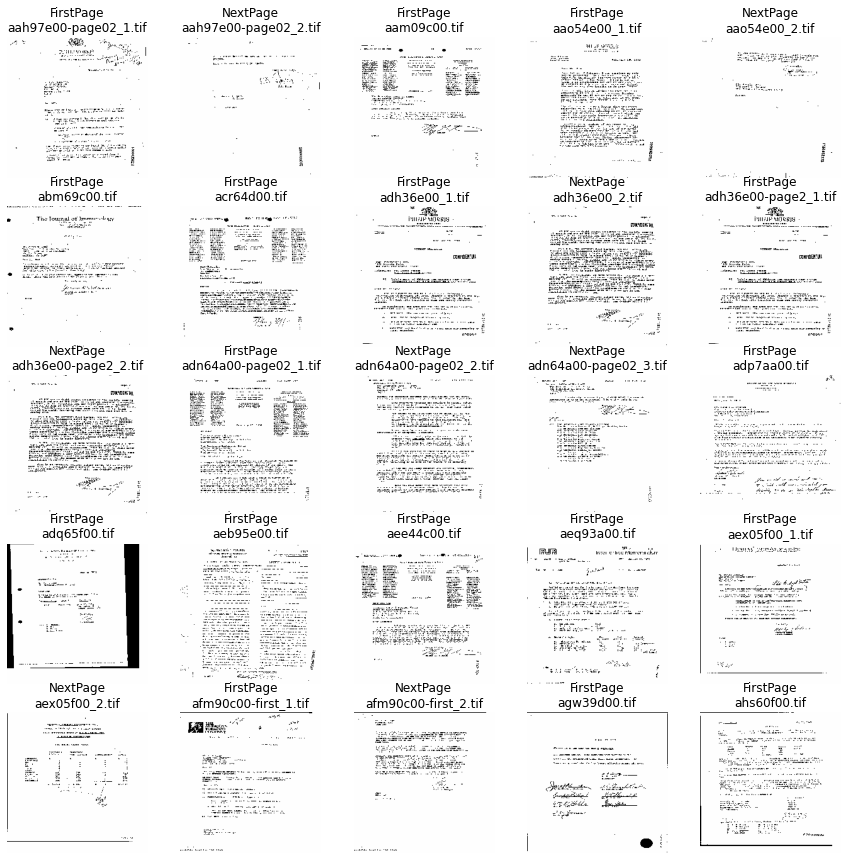

In [15]:
N_IMAGES = 25

images, labels, file_names = zip(*[(image, label, file_name) for image, label, file_name in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = {1: 'FirstPage', 0: 'NextPage'}

plot_images(images, labels, classes, file_names)

As the model is ~5x the size of the AlexNet model from the previous notebook we use a smaller batch size so it can fit on reasonably sized GPUs. This should be increased if we have access to GPUs with more memory in order to speed up training.

In [16]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 batch_size = BATCH_SIZE, shuffle=False)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, 
                                 batch_size = BATCH_SIZE)

### Training the Model

We'll use the learning rate finder as used in previous notebooks. Generally when using a pre-trained model the learning rate used will be considerably lower.

First, we'll set up the optimizer with the initial learning rate that is much lower than we expect to use. Then we define the `device` to place our model on our GPU, if we have one. Next we define the `criterion` (loss function) and place the model and criterion on our device.

In [17]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr = START_LR)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [43]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'TOBACCO_SINGLE_PAGE_EFF_v2.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            #update lr
            lr_scheduler.step()
            
            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels, name = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [ ]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

In [ ]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

In [ ]:
plot_lr_finder(lrs, losses, skip_start = 10, skip_end = 20)

In [18]:
FOUND_LR = 5e-3

params = [
          {'params': model.base_model.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr = FOUND_LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [19]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...create a function that implements a training loop...

In [20]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_kappa = 0
    
    model.train()
    
    for (x, y, name) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        top_pred = y_pred.argmax(1, keepdim = True)
        
        kappa = cohen_kappa_score(y.tolist(), top_pred.flatten().cpu())
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_kappa += 1.0 if math.isnan(kappa) else kappa
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_kappa / len(iterator)

...create a function that performs an evaluation loop...

In [21]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_kappa = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y, name) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            top_pred = y_pred.argmax(1, keepdim = True)
        
            kappa = cohen_kappa_score(y.tolist(), top_pred.flatten().cpu())

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_kappa += 1.0 if math.isnan(kappa) else kappa
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_kappa / len(iterator)

Finally, we train our model.

As our images have been resized to be significantly larger and our model has significantly more parameters training takes considerably longer. However, when performing transfer learning we usually train for significantly less epochs and are still able to achieve much higher accuracy than before.

In [23]:
EPOCHS = 20

best_valid_loss = float('inf')

experiment_data = []

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc, train_kappa = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc, valid_kappa = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print (f'Winner Epoch: {epoch+1:02}.')
        torch.save(model.state_dict(), './model/'+ EXPERIMENT+ '.pt')
        
    scheduler.step(valid_loss)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train Kappa: {train_kappa*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% |  Val. Kappa: {valid_kappa*100:.2f}%')

    experiment_data.append([train_loss, valid_loss, train_acc, valid_acc, train_kappa, valid_kappa, start_time, end_time])
    experiment_df = pd.DataFrame(experiment_data,columns=['train_loss','valid_loss','train_acc', 'valid_acc','test_kappa', 'valid_kappa','start', 'end' ])
    experiment_df.to_pickle('./model/'+ EXPERIMENT+ '.pk')

Winner Epoch: 01.
Epoch: 01 | Epoch Time: 0m 20s
	Train Loss: 0.644 | Train Acc: 65.96% | Train Kappa: 28.09%
	 Val. Loss: 0.675 |  Val. Acc: 56.25% |  Val. Kappa: -0.74%
Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 0.527 | Train Acc: 82.56% | Train Kappa: 63.89%
	 Val. Loss: 0.678 |  Val. Acc: 55.36% |  Val. Kappa: -0.11%
Epoch: 03 | Epoch Time: 0m 17s
	Train Loss: 0.454 | Train Acc: 89.66% | Train Kappa: 78.84%
	 Val. Loss: 0.688 |  Val. Acc: 55.36% |  Val. Kappa: 0.00%
Epoch: 04 | Epoch Time: 0m 17s
	Train Loss: 0.413 | Train Acc: 92.43% | Train Kappa: 84.22%
	 Val. Loss: 0.697 |  Val. Acc: 55.80% |  Val. Kappa: 0.54%
Epoch: 05 | Epoch Time: 0m 17s
	Train Loss: 0.378 | Train Acc: 95.07% | Train Kappa: 88.99%
	 Val. Loss: 0.707 |  Val. Acc: 55.80% |  Val. Kappa: 0.54%
Epoch: 06 | Epoch Time: 0m 17s
	Train Loss: 0.367 | Train Acc: 95.55% | Train Kappa: 90.30%
	 Val. Loss: 0.682 |  Val. Acc: 57.14% |  Val. Kappa: 3.29%
Winner Epoch: 07.
Epoch: 07 | Epoch Time: 0m 18s
	Train Loss: 0.359 

## test split 8 w bn

```shell
Winner Epoch: 01.
Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 0.630 | Train Acc: 65.75% | Train Kappa: 33.49%
	 Val. Loss: 0.671 |  Val. Acc: 55.19% |  Val. Kappa: -0.91%
Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 0.449 | Train Acc: 88.82% | Train Kappa: 76.39%
	 Val. Loss: 0.674 |  Val. Acc: 56.97% |  Val. Kappa: 2.38%
Epoch: 03 | Epoch Time: 0m 33s
	Train Loss: 0.387 | Train Acc: 93.99% | Train Kappa: 87.27%
	 Val. Loss: 0.685 |  Val. Acc: 55.19% |  Val. Kappa: -0.91%
Epoch: 04 | Epoch Time: 0m 21s
	Train Loss: 0.362 | Train Acc: 95.79% | Train Kappa: 91.36%
	 Val. Loss: 0.678 |  Val. Acc: 55.63% |  Val. Kappa: 0.16%
Winner Epoch: 05.
Epoch: 05 | Epoch Time: 0m 26s
	Train Loss: 0.347 | Train Acc: 97.72% | Train Kappa: 94.89%
	 Val. Loss: 0.670 |  Val. Acc: 55.19% |  Val. Kappa: -0.97%
Winner Epoch: 06.
Epoch: 06 | Epoch Time: 0m 36s
	Train Loss: 0.340 | Train Acc: 97.60% | Train Kappa: 94.58%
	 Val. Loss: 0.606 |  Val. Acc: 65.45% |  Val. Kappa: 24.45%
Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 0.334 | Train Acc: 98.44% | Train Kappa: 96.60%
	 Val. Loss: 0.627 |  Val. Acc: 63.87% |  Val. Kappa: 25.16%
Epoch: 08 | Epoch Time: 0m 20s
	Train Loss: 0.333 | Train Acc: 98.56% | Train Kappa: 96.76%
	 Val. Loss: 0.619 |  Val. Acc: 65.01% |  Val. Kappa: 26.66%
Epoch: 09 | Epoch Time: 0m 30s
	Train Loss: 0.329 | Train Acc: 98.92% | Train Kappa: 97.58%
	 Val. Loss: 0.611 |  Val. Acc: 66.11% |  Val. Kappa: 29.45%
Epoch: 10 | Epoch Time: 0m 35s
	Train Loss: 0.323 | Train Acc: 99.40% | Train Kappa: 98.63%
	 Val. Loss: 0.616 |  Val. Acc: 66.55% |  Val. Kappa: 29.42%

```

## test split 10 w bn
```shell
Winner Epoch: 01.
Epoch: 01 | Epoch Time: 0m 38s
	Train Loss: 0.620 | Train Acc: 70.11% | Train Kappa: 36.99%
	 Val. Loss: 0.671 |  Val. Acc: 55.22% |  Val. Kappa: -1.48%
Epoch: 02 | Epoch Time: 0m 21s
	Train Loss: 0.456 | Train Acc: 88.07% | Train Kappa: 75.23%
	 Val. Loss: 0.677 |  Val. Acc: 55.63% |  Val. Kappa: -0.29%
Epoch: 03 | Epoch Time: 0m 20s
	Train Loss: 0.381 | Train Acc: 94.71% | Train Kappa: 88.96%
	 Val. Loss: 0.685 |  Val. Acc: 55.63% |  Val. Kappa: -0.48%
Epoch: 04 | Epoch Time: 0m 31s
	Train Loss: 0.357 | Train Acc: 96.39% | Train Kappa: 92.29%
	 Val. Loss: 0.719 |  Val. Acc: 55.63% |  Val. Kappa: 0.00%
Epoch: 05 | Epoch Time: 0m 27s
	Train Loss: 0.350 | Train Acc: 96.61% | Train Kappa: 92.47%
	 Val. Loss: 0.729 |  Val. Acc: 56.08% |  Val. Kappa: 1.01%
Epoch: 06 | Epoch Time: 0m 20s
	Train Loss: 0.344 | Train Acc: 97.36% | Train Kappa: 94.12%
	 Val. Loss: 0.719 |  Val. Acc: 56.97% |  Val. Kappa: 1.97%
Winner Epoch: 07.
Epoch: 07 | Epoch Time: 0m 27s
	Train Loss: 0.337 | Train Acc: 97.90% | Train Kappa: 95.26%
	 Val. Loss: 0.637 |  Val. Acc: 64.32% |  Val. Kappa: 21.42%
Winner Epoch: 08.
Epoch: 08 | Epoch Time: 0m 37s
	Train Loss: 0.337 | Train Acc: 98.32% | Train Kappa: 96.12%
	 Val. Loss: 0.605 |  Val. Acc: 66.35% |  Val. Kappa: 21.87%
Winner Epoch: 09.
Epoch: 09 | Epoch Time: 0m 26s
	Train Loss: 0.333 | Train Acc: 98.56% | Train Kappa: 96.72%
	 Val. Loss: 0.571 |  Val. Acc: 73.70% |  Val. Kappa: 44.42%
Epoch: 10 | Epoch Time: 0m 26s
	Train Loss: 0.332 | Train Acc: 98.44% | Train Kappa: 96.21%
	 Val. Loss: 0.593 |  Val. Acc: 69.92% |  Val. Kappa: 32.98%
```

## test split 12 
```shell
Winner Epoch: 01.
Epoch: 01 | Epoch Time: 0m 21s
	Train Loss: 0.629 | Train Acc: 67.89% | Train Kappa: 32.83%
	 Val. Loss: 0.683 |  Val. Acc: 55.63% |  Val. Kappa: 0.00%
Epoch: 02 | Epoch Time: 0m 18s
	Train Loss: 0.463 | Train Acc: 87.86% | Train Kappa: 74.13%
	 Val. Loss: 0.693 |  Val. Acc: 55.63% |  Val. Kappa: 0.00%
Epoch: 03 | Epoch Time: 0m 18s
	Train Loss: 0.400 | Train Acc: 92.55% | Train Kappa: 84.25%
	 Val. Loss: 0.728 |  Val. Acc: 55.63% |  Val. Kappa: 0.00%
Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 0.364 | Train Acc: 96.15% | Train Kappa: 91.94%
	 Val. Loss: 0.723 |  Val. Acc: 55.63% |  Val. Kappa: 0.00%
Epoch: 05 | Epoch Time: 0m 18s
	Train Loss: 0.355 | Train Acc: 96.37% | Train Kappa: 92.31%
	 Val. Loss: 0.735 |  Val. Acc: 56.08% |  Val. Kappa: 0.41%
Epoch: 06 | Epoch Time: 0m 18s
	Train Loss: 0.350 | Train Acc: 97.12% | Train Kappa: 93.48%
	 Val. Loss: 0.709 |  Val. Acc: 56.52% |  Val. Kappa: 0.69%
Winner Epoch: 07.
Epoch: 07 | Epoch Time: 0m 20s
	Train Loss: 0.345 | Train Acc: 97.60% | Train Kappa: 94.70%
	 Val. Loss: 0.648 |  Val. Acc: 64.56% |  Val. Kappa: 17.36%
Epoch: 08 | Epoch Time: 0m 17s
	Train Loss: 0.338 | Train Acc: 98.44% | Train Kappa: 96.30%
	 Val. Loss: 0.652 |  Val. Acc: 63.22% |  Val. Kappa: 18.35%
Winner Epoch: 09.
Epoch: 09 | Epoch Time: 0m 20s
	Train Loss: 0.334 | Train Acc: 98.32% | Train Kappa: 96.02%
	 Val. Loss: 0.632 |  Val. Acc: 64.56% |  Val. Kappa: 27.14%
Winner Epoch: 10.
Epoch: 10 | Epoch Time: 0m 21s
	Train Loss: 0.338 | Train Acc: 97.93% | Train Kappa: 95.32%
	 Val. Loss: 0.602 |  Val. Acc: 68.13% |  Val. Kappa: 33.09%
```

## test split 15 no bn
```shell
Winner Epoch: 01.
Epoch: 01 | Epoch Time: 0m 40s
	Train Loss: 0.652 | Train Acc: 64.74% | Train Kappa: 25.45%
	 Val. Loss: 0.679 |  Val. Acc: 53.50% |  Val. Kappa: 0.56%
Winner Epoch: 02.
Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 0.558 | Train Acc: 78.71% | Train Kappa: 54.93%
	 Val. Loss: 0.673 |  Val. Acc: 56.52% |  Val. Kappa: 0.98%
Epoch: 03 | Epoch Time: 0m 17s
	Train Loss: 0.503 | Train Acc: 84.59% | Train Kappa: 67.83%
	 Val. Loss: 0.673 |  Val. Acc: 56.08% |  Val. Kappa: 0.72%
Epoch: 04 | Epoch Time: 0m 17s
	Train Loss: 0.462 | Train Acc: 88.91% | Train Kappa: 77.02%
	 Val. Loss: 0.682 |  Val. Acc: 56.08% |  Val. Kappa: 1.01%
Epoch: 05 | Epoch Time: 0m 17s
	Train Loss: 0.423 | Train Acc: 92.16% | Train Kappa: 83.93%
	 Val. Loss: 0.687 |  Val. Acc: 55.63% |  Val. Kappa: 0.12%
Winner Epoch: 06.
Epoch: 06 | Epoch Time: 0m 19s
	Train Loss: 0.394 | Train Acc: 94.68% | Train Kappa: 88.60%
	 Val. Loss: 0.664 |  Val. Acc: 58.76% |  Val. Kappa: 6.55%
Winner Epoch: 07.
Epoch: 07 | Epoch Time: 0m 19s
	Train Loss: 0.376 | Train Acc: 96.39% | Train Kappa: 92.02%
	 Val. Loss: 0.646 |  Val. Acc: 63.87% |  Val. Kappa: 20.40%
Winner Epoch: 08.
Epoch: 08 | Epoch Time: 0m 19s
	Train Loss: 0.366 | Train Acc: 96.51% | Train Kappa: 92.17%
	 Val. Loss: 0.641 |  Val. Acc: 61.44% |  Val. Kappa: 15.52%
Epoch: 09 | Epoch Time: 0m 17s
	Train Loss: 0.352 | Train Acc: 97.48% | Train Kappa: 94.34%
	 Val. Loss: 0.643 |  Val. Acc: 61.64% |  Val. Kappa: 16.11%
Epoch: 10 | Epoch Time: 0m 17s
	Train Loss: 0.346 | Train Acc: 98.32% | Train Kappa: 96.31%
	 Val. Loss: 0.651 |  Val. Acc: 61.20% |  Val. Kappa: 14.90%
```

## No test split
```shell

Winner Epoch: 01, so far.
Epoch: 01 | Epoch Time: 1m 16s
	Train Loss: 0.633 | Train Acc: 68.11% | Train Kappa: 33.43%
	 Val. Loss: 0.828 |  Val. Acc: 40.86% |  Val. Kappa: -0.69%
Epoch: 02 | Epoch Time: 1m 13s
	Train Loss: 0.490 | Train Acc: 85.13% | Train Kappa: 69.49%
	 Val. Loss: 0.844 |  Val. Acc: 41.20% |  Val. Kappa: 0.00%
Epoch: 03 | Epoch Time: 1m 11s
	Train Loss: 0.422 | Train Acc: 90.91% | Train Kappa: 80.70%
	 Val. Loss: 0.837 |  Val. Acc: 41.55% |  Val. Kappa: 0.69%
Winner Epoch: 04, so far.
Epoch: 04 | Epoch Time: 1m 13s
	Train Loss: 0.392 | Train Acc: 93.84% | Train Kappa: 86.69%
	 Val. Loss: 0.809 |  Val. Acc: 43.29% |  Val. Kappa: 2.63%
Winner Epoch: 05, so far.
Epoch: 05 | Epoch Time: 1m 12s
	Train Loss: 0.379 | Train Acc: 94.22% | Train Kappa: 87.25%
	 Val. Loss: 0.696 |  Val. Acc: 55.67% |  Val. Kappa: 19.85%
Winner Epoch: 06, so far.
Epoch: 06 | Epoch Time: 1m 12s
	Train Loss: 0.361 | Train Acc: 96.02% | Train Kappa: 91.02%
	 Val. Loss: 0.590 |  Val. Acc: 71.30% |  Val. Kappa: 42.91%
Winner Epoch: 07, so far.
Epoch: 07 | Epoch Time: 1m 13s
	Train Loss: 0.346 | Train Acc: 98.11% | Train Kappa: 95.66%
	 Val. Loss: 0.570 |  Val. Acc: 72.34% |  Val. Kappa: 44.01%
Epoch: 08 | Epoch Time: 1m 12s
	Train Loss: 0.342 | Train Acc: 97.92% | Train Kappa: 95.08%
	 Val. Loss: 0.582 |  Val. Acc: 69.91% |  Val. Kappa: 37.53%
Epoch: 09 | Epoch Time: 1m 12s
	Train Loss: 0.344 | Train Acc: 97.82% | Train Kappa: 94.92%
	 Val. Loss: 0.650 |  Val. Acc: 60.65% |  Val. Kappa: 26.32%
Epoch: 10 | Epoch Time: 1m 13s
	Train Loss: 0.338 | Train Acc: 98.11% | Train Kappa: 95.72%
	 Val. Loss: 0.608 |  Val. Acc: 67.48% |  Val. Kappa: 34.41%
Epoch: 11 | Epoch Time: 1m 11s
	Train Loss: 0.346 | Train Acc: 97.16% | Train Kappa: 93.28%
	 Val. Loss: 0.619 |  Val. Acc: 62.73% |  Val. Kappa: 28.42%
Epoch: 12 | Epoch Time: 1m 12s
	Train Loss: 0.337 | Train Acc: 98.01% | Train Kappa: 95.41%
	 Val. Loss: 0.610 |  Val. Acc: 66.78% |  Val. Kappa: 31.39%
Epoch: 13 | Epoch Time: 1m 12s
	Train Loss: 0.332 | Train Acc: 98.96% | Train Kappa: 97.33%
	 Val. Loss: 0.608 |  Val. Acc: 67.82% |  Val. Kappa: 31.41%
Epoch: 14 | Epoch Time: 1m 12s
	Train Loss: 0.332 | Train Acc: 98.77% | Train Kappa: 97.21%
	 Val. Loss: 0.626 |  Val. Acc: 62.73% |  Val. Kappa: 23.89%
Epoch: 15 | Epoch Time: 1m 12s
	Train Loss: 0.331 | Train Acc: 98.48% | Train Kappa: 96.47%
	 Val. Loss: 0.625 |  Val. Acc: 64.35% |  Val. Kappa: 16.71%
Epoch: 16 | Epoch Time: 1m 11s
	Train Loss: 0.329 | Train Acc: 99.05% | Train Kappa: 97.36%
	 Val. Loss: 0.614 |  Val. Acc: 66.09% |  Val. Kappa: 21.02%
Winner Epoch: 17, so far.
Epoch: 17 | Epoch Time: 1m 13s
	Train Loss: 0.328 | Train Acc: 98.86% | Train Kappa: 97.34%
	 Val. Loss: 0.567 |  Val. Acc: 75.35% |  Val. Kappa: 46.83%
Epoch: 18 | Epoch Time: 1m 14s
	Train Loss: 0.323 | Train Acc: 99.43% | Train Kappa: 98.57%
	 Val. Loss: 0.573 |  Val. Acc: 71.99% |  Val. Kappa: 37.86%
Winner Epoch: 19, so far.
Epoch: 19 | Epoch Time: 1m 13s
	Train Loss: 0.328 | Train Acc: 98.67% | Train Kappa: 97.05%
	 Val. Loss: 0.557 |  Val. Acc: 75.00% |  Val. Kappa: 46.43%
Winner Epoch: 20, so far.
Epoch: 20 | Epoch Time: 1m 12s
	Train Loss: 0.324 | Train Acc: 99.15% | Train Kappa: 98.06%
	 Val. Loss: 0.552 |  Val. Acc: 73.96% |  Val. Kappa: 44.41%
Winner Epoch: 21, so far.
Epoch: 21 | Epoch Time: 1m 12s
	Train Loss: 0.328 | Train Acc: 98.71% | Train Kappa: 96.85%
	 Val. Loss: 0.532 |  Val. Acc: 76.74% |  Val. Kappa: 49.60%
Epoch: 22 | Epoch Time: 1m 11s
	Train Loss: 0.332 | Train Acc: 98.24% | Train Kappa: 95.98%
	 Val. Loss: 0.558 |  Val. Acc: 73.96% |  Val. Kappa: 40.47%
Winner Epoch: 23, so far.
Epoch: 23 | Epoch Time: 1m 13s
	Train Loss: 0.326 | Train Acc: 98.86% | Train Kappa: 97.36%
	 Val. Loss: 0.492 |  Val. Acc: 82.64% |  Val. Kappa: 62.09%
Winner Epoch: 24, so far.
Epoch: 24 | Epoch Time: 1m 13s
	Train Loss: 0.324 | Train Acc: 99.15% | Train Kappa: 97.93%
	 Val. Loss: 0.475 |  Val. Acc: 83.33% |  Val. Kappa: 64.23%
Winner Epoch: 25, so far.
Epoch: 25 | Epoch Time: 1m 11s
	Train Loss: 0.324 | Train Acc: 99.15% | Train Kappa: 97.99%
	 Val. Loss: 0.467 |  Val. Acc: 84.03% |  Val. Kappa: 66.62%
Epoch: 26 | Epoch Time: 1m 11s
	Train Loss: 0.323 | Train Acc: 99.24% | Train Kappa: 98.13%
	 Val. Loss: 0.483 |  Val. Acc: 82.29% |  Val. Kappa: 61.55%
Winner Epoch: 27, so far.
Epoch: 27 | Epoch Time: 1m 12s
	Train Loss: 0.322 | Train Acc: 99.24% | Train Kappa: 97.83%
	 Val. Loss: 0.458 |  Val. Acc: 85.42% |  Val. Kappa: 69.21%
Winner Epoch: 28, so far.
Epoch: 28 | Epoch Time: 1m 13s
	Train Loss: 0.321 | Train Acc: 99.34% | Train Kappa: 98.30%
	 Val. Loss: 0.442 |  Val. Acc: 87.85% |  Val. Kappa: 75.03%
Epoch: 29 | Epoch Time: 1m 13s
	Train Loss: 0.321 | Train Acc: 99.34% | Train Kappa: 98.37%
	 Val. Loss: 0.443 |  Val. Acc: 86.46% |  Val. Kappa: 72.03%
Epoch: 30 | Epoch Time: 1m 12s
	Train Loss: 0.318 | Train Acc: 99.72% | Train Kappa: 99.18%
	 Val. Loss: 0.449 |  Val. Acc: 85.76% |  Val. Kappa: 70.63%
Epoch: 31 | Epoch Time: 1m 12s
	Train Loss: 0.325 | Train Acc: 99.00% | Train Kappa: 97.71%
	 Val. Loss: 0.457 |  Val. Acc: 84.72% |  Val. Kappa: 67.99%
Epoch: 32 | Epoch Time: 1m 13s
	Train Loss: 0.322 | Train Acc: 99.24% | Train Kappa: 98.09%
	 Val. Loss: 0.449 |  Val. Acc: 87.15% |  Val. Kappa: 73.34%
Epoch: 33 | Epoch Time: 1m 12s
	Train Loss: 0.324 | Train Acc: 99.05% | Train Kappa: 97.58%
	 Val. Loss: 0.458 |  Val. Acc: 86.11% |  Val. Kappa: 70.76%
Epoch: 34 | Epoch Time: 1m 12s
	Train Loss: 0.321 | Train Acc: 99.53% | Train Kappa: 98.80%
	 Val. Loss: 0.457 |  Val. Acc: 85.76% |  Val. Kappa: 70.45%
Epoch: 35 | Epoch Time: 1m 12s
	Train Loss: 0.323 | Train Acc: 99.15% | Train Kappa: 97.88%
	 Val. Loss: 0.448 |  Val. Acc: 86.11% |  Val. Kappa: 71.11%
Epoch: 36 | Epoch Time: 1m 13s
	Train Loss: 0.319 | Train Acc: 99.62% | Train Kappa: 98.91%
	 Val. Loss: 0.461 |  Val. Acc: 84.38% |  Val. Kappa: 67.40%
Epoch: 37 | Epoch Time: 1m 13s
	Train Loss: 0.320 | Train Acc: 99.34% | Train Kappa: 98.39%
	 Val. Loss: 0.454 |  Val. Acc: 85.76% |  Val. Kappa: 70.59%
Winner Epoch: 38, so far.
Epoch: 38 | Epoch Time: 1m 12s
	Train Loss: 0.323 | Train Acc: 99.34% | Train Kappa: 98.24%
	 Val. Loss: 0.440 |  Val. Acc: 87.85% |  Val. Kappa: 74.79%
Epoch: 39 | Epoch Time: 1m 13s
	Train Loss: 0.319 | Train Acc: 99.62% | Train Kappa: 98.93%
	 Val. Loss: 0.441 |  Val. Acc: 87.15% |  Val. Kappa: 73.32%
Epoch: 40 | Epoch Time: 1m 12s
	Train Loss: 0.320 | Train Acc: 99.43% | Train Kappa: 98.58%
	 Val. Loss: 0.452 |  Val. Acc: 86.11% |  Val. Kappa: 70.98%
     
```


15

Winner Epoch: 01, so far.
Epoch: 01 | Epoch Time: 0m 34s
	Train Loss: 0.660 | Train Acc: 62.23% | Train Kappa: 21.81%
	 Val. Loss: 0.706 |  Val. Acc: 40.86% |  Val. Kappa: -0.69%
Epoch: 02 | Epoch Time: 0m 33s
	Train Loss: 0.560 | Train Acc: 78.35% | Train Kappa: 55.27%
	 Val. Loss: 0.736 |  Val. Acc: 40.86% |  Val. Kappa: -0.69%
Epoch: 03 | Epoch Time: 0m 32s
	Train Loss: 0.501 | Train Acc: 84.85% | Train Kappa: 68.85%
	 Val. Loss: 0.758 |  Val. Acc: 41.90% |  Val. Kappa: 1.02%
Epoch: 04 | Epoch Time: 0m 33s
	Train Loss: 0.458 | Train Acc: 87.97% | Train Kappa: 74.90%
	 Val. Loss: 0.729 |  Val. Acc: 44.68% |  Val. Kappa: 3.87%
Winner Epoch: 05, so far.
Epoch: 05 | Epoch Time: 0m 34s
	Train Loss: 0.413 | Train Acc: 94.22% | Train Kappa: 87.61%
	 Val. Loss: 0.680 |  Val. Acc: 53.01% |  Val. Kappa: 16.19%
Winner Epoch: 06, so far.
Epoch: 06 | Epoch Time: 0m 34s
	Train Loss: 0.392 | Train Acc: 94.89% | Train Kappa: 88.63%
	 Val. Loss: 0.637 |  Val. Acc: 63.66% |  Val. Kappa: 30.66%
Winner Epoch: 07, so far.
Epoch: 07 | Epoch Time: 0m 30s
	Train Loss: 0.379 | Train Acc: 95.45% | Train Kappa: 89.60%
	 Val. Loss: 0.614 |  Val. Acc: 69.21% |  Val. Kappa: 38.02%
Epoch: 08 | Epoch Time: 0m 30s
	Train Loss: 0.365 | Train Acc: 96.21% | Train Kappa: 91.01%
	 Val. Loss: 0.628 |  Val. Acc: 66.78% |  Val. Kappa: 33.60%
Epoch: 09 | Epoch Time: 0m 32s
	Train Loss: 0.361 | Train Acc: 96.78% | Train Kappa: 92.52%
	 Val. Loss: 0.643 |  Val. Acc: 63.08% |  Val. Kappa: 30.79%
Epoch: 10 | Epoch Time: 0m 30s
	Train Loss: 0.352 | Train Acc: 97.06% | Train Kappa: 93.14%
	 Val. Loss: 0.685 |  Val. Acc: 58.56% |  Val. Kappa: 24.74%
Epoch: 11 | Epoch Time: 0m 31s
	Train Loss: 0.345 | Train Acc: 98.11% | Train Kappa: 95.53%
	 Val. Loss: 0.690 |  Val. Acc: 58.91% |  Val. Kappa: 25.80%
Epoch: 12 | Epoch Time: 0m 27s
	Train Loss: 0.341 | Train Acc: 98.39% | Train Kappa: 96.09%
	 Val. Loss: 0.639 |  Val. Acc: 63.43% |  Val. Kappa: 30.92%
Epoch: 13 | Epoch Time: 0m 28s
	Train Loss: 0.339 | Train Acc: 98.58% | Train Kappa: 96.68%
	 Val. Loss: 0.657 |  Val. Acc: 63.08% |  Val. Kappa: 30.47%
Epoch: 14 | Epoch Time: 0m 28s
	Train Loss: 0.340 | Train Acc: 98.39% | Train Kappa: 96.11%
	 Val. Loss: 0.676 |  Val. Acc: 60.65% |  Val. Kappa: 26.27%
Epoch: 15 | Epoch Time: 0m 29s
	Train Loss: 0.333 | Train Acc: 98.96% | Train Kappa: 97.40%
	 Val. Loss: 0.646 |  Val. Acc: 63.08% |  Val. Kappa: 28.73%
Winner Epoch: 16, so far.
Epoch: 16 | Epoch Time: 0m 28s
	Train Loss: 0.335 | Train Acc: 98.48% | Train Kappa: 96.15%
	 Val. Loss: 0.614 |  Val. Acc: 67.82% |  Val. Kappa: 32.97%
Winner Epoch: 17, so far.
Epoch: 17 | Epoch Time: 0m 29s
	Train Loss: 0.334 | Train Acc: 98.39% | Train Kappa: 96.21%
	 Val. Loss: 0.609 |  Val. Acc: 68.87% |  Val. Kappa: 34.46%
Epoch: 18 | Epoch Time: 0m 28s
	Train Loss: 0.330 | Train Acc: 98.86% | Train Kappa: 97.24%
	 Val. Loss: 0.644 |  Val. Acc: 64.47% |  Val. Kappa: 31.58%
Epoch: 19 | Epoch Time: 0m 30s
	Train Loss: 0.333 | Train Acc: 98.39% | Train Kappa: 96.28%
	 Val. Loss: 0.617 |  Val. Acc: 67.48% |  Val. Kappa: 33.30%
Winner Epoch: 20, so far.
Epoch: 20 | Epoch Time: 0m 41s
	Train Loss: 0.331 | Train Acc: 98.86% | Train Kappa: 97.47%
	 Val. Loss: 0.578 |  Val. Acc: 72.57% |  Val. Kappa: 42.63%
Winner Epoch: 21, so far.
Epoch: 21 | Epoch Time: 1m 11s
	Train Loss: 0.329 | Train Acc: 99.24% | Train Kappa: 98.22%
	 Val. Loss: 0.555 |  Val. Acc: 73.96% |  Val. Kappa: 43.17%
Winner Epoch: 22, so far.
Epoch: 22 | Epoch Time: 1m 13s
	Train Loss: 0.328 | Train Acc: 98.86% | Train Kappa: 97.35%
	 Val. Loss: 0.543 |  Val. Acc: 75.35% |  Val. Kappa: 47.45%
Winner Epoch: 23, so far.
Epoch: 23 | Epoch Time: 1m 12s
	Train Loss: 0.326 | Train Acc: 99.24% | Train Kappa: 98.23%
	 Val. Loss: 0.503 |  Val. Acc: 80.90% |  Val. Kappa: 59.76%
Epoch: 24 | Epoch Time: 1m 13s
	Train Loss: 0.326 | Train Acc: 99.34% | Train Kappa: 98.42%
	 Val. Loss: 0.503 |  Val. Acc: 78.82% |  Val. Kappa: 55.05%
Winner Epoch: 25, so far.
Epoch: 25 | Epoch Time: 1m 13s
	Train Loss: 0.324 | Train Acc: 99.43% | Train Kappa: 98.67%
	 Val. Loss: 0.492 |  Val. Acc: 81.25% |  Val. Kappa: 60.59%
Epoch: 26 | Epoch Time: 1m 13s
	Train Loss: 0.330 | Train Acc: 98.81% | Train Kappa: 97.41%
	 Val. Loss: 0.493 |  Val. Acc: 79.86% |  Val. Kappa: 57.87%
Winner Epoch: 27, so far.
Epoch: 27 | Epoch Time: 1m 12s
	Train Loss: 0.328 | Train Acc: 98.86% | Train Kappa: 97.33%
	 Val. Loss: 0.488 |  Val. Acc: 81.94% |  Val. Kappa: 62.07%
Epoch: 28 | Epoch Time: 1m 11s
	Train Loss: 0.324 | Train Acc: 99.24% | Train Kappa: 98.38%
	 Val. Loss: 0.517 |  Val. Acc: 78.12% |  Val. Kappa: 53.41%
Epoch: 29 | Epoch Time: 1m 12s
	Train Loss: 0.325 | Train Acc: 99.24% | Train Kappa: 98.21%
	 Val. Loss: 0.533 |  Val. Acc: 75.58% |  Val. Kappa: 52.71%
Epoch: 30 | Epoch Time: 1m 11s
	Train Loss: 0.322 | Train Acc: 99.53% | Train Kappa: 98.98%
	 Val. Loss: 0.521 |  Val. Acc: 79.28% |  Val. Kappa: 57.75%
Epoch: 31 | Epoch Time: 1m 12s
	Train Loss: 0.323 | Train Acc: 99.43% | Train Kappa: 98.73%
	 Val. Loss: 0.523 |  Val. Acc: 77.66% |  Val. Kappa: 57.44%
Epoch: 32 | Epoch Time: 1m 12s
	Train Loss: 0.322 | Train Acc: 99.43% | Train Kappa: 98.73%
	 Val. Loss: 0.511 |  Val. Acc: 79.28% |  Val. Kappa: 57.41%
Epoch: 33 | Epoch Time: 1m 13s
	Train Loss: 0.320 | Train Acc: 99.72% | Train Kappa: 99.26%
	 Val. Loss: 0.493 |  Val. Acc: 80.32% |  Val. Kappa: 59.78%

## FT 11 NOVO
```shell
Winner Epoch: 01, so far.
Epoch: 01 | Epoch Time: 0m 34s
	Train Loss: 0.585 | Train Acc: 71.06% | Train Kappa: 36.55%
	 Val. Loss: 0.741 |  Val. Acc: 42.25% |  Val. Kappa: 0.42%
Epoch: 02 | Epoch Time: 0m 34s
	Train Loss: 0.445 | Train Acc: 86.17% | Train Kappa: 71.56%
	 Val. Loss: 0.760 |  Val. Acc: 46.99% |  Val. Kappa: 6.51%
Epoch: 03 | Epoch Time: 0m 35s
	Train Loss: 0.414 | Train Acc: 89.91% | Train Kappa: 78.99%
	 Val. Loss: 0.764 |  Val. Acc: 48.73% |  Val. Kappa: 9.11%
Winner Epoch: 04, so far.
Epoch: 04 | Epoch Time: 0m 33s
	Train Loss: 0.392 | Train Acc: 91.76% | Train Kappa: 82.38%
	 Val. Loss: 0.738 |  Val. Acc: 50.93% |  Val. Kappa: 13.68%
Winner Epoch: 05, so far.
Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 0.377 | Train Acc: 94.03% | Train Kappa: 87.09%
	 Val. Loss: 0.614 |  Val. Acc: 68.40% |  Val. Kappa: 38.47%
Epoch: 06 | Epoch Time: 0m 34s
	Train Loss: 0.374 | Train Acc: 93.94% | Train Kappa: 87.27%
	 Val. Loss: 0.725 |  Val. Acc: 55.44% |  Val. Kappa: 19.39%
Epoch: 07 | Epoch Time: 0m 35s
	Train Loss: 0.376 | Train Acc: 93.75% | Train Kappa: 86.49%
	 Val. Loss: 0.668 |  Val. Acc: 61.00% |  Val. Kappa: 27.81%
Winner Epoch: 08, so far.
Epoch: 08 | Epoch Time: 0m 34s
	Train Loss: 0.370 | Train Acc: 93.94% | Train Kappa: 86.49%
	 Val. Loss: 0.607 |  Val. Acc: 67.82% |  Val. Kappa: 35.06%
Epoch: 09 | Epoch Time: 0m 32s
	Train Loss: 0.370 | Train Acc: 94.32% | Train Kappa: 87.70%
	 Val. Loss: 0.714 |  Val. Acc: 55.79% |  Val. Kappa: 17.39%
Epoch: 10 | Epoch Time: 0m 34s
	Train Loss: 0.365 | Train Acc: 94.79% | Train Kappa: 88.17%
	 Val. Loss: 0.658 |  Val. Acc: 60.65% |  Val. Kappa: 26.58%
Epoch: 11 | Epoch Time: 0m 32s
	Train Loss: 0.366 | Train Acc: 94.55% | Train Kappa: 87.61%
	 Val. Loss: 0.827 |  Val. Acc: 46.41% |  Val. Kappa: 6.07%
Epoch: 12 | Epoch Time: 0m 34s
	Train Loss: 0.394 | Train Acc: 91.71% | Train Kappa: 82.03%
	 Val. Loss: 0.646 |  Val. Acc: 65.05% |  Val. Kappa: 32.91%
Winner Epoch: 13, so far.
Epoch: 13 | Epoch Time: 0m 33s
	Train Loss: 0.381 | Train Acc: 92.90% | Train Kappa: 84.15%
	 Val. Loss: 0.600 |  Val. Acc: 68.52% |  Val. Kappa: 38.98%
Winner Epoch: 14, so far.
Epoch: 14 | Epoch Time: 0m 31s
	Train Loss: 0.377 | Train Acc: 93.47% | Train Kappa: 85.81%
	 Val. Loss: 0.532 |  Val. Acc: 76.74% |  Val. Kappa: 51.56%
Winner Epoch: 15, so far.
Epoch: 15 | Epoch Time: 0m 30s
	Train Loss: 0.367 | Train Acc: 94.79% | Train Kappa: 88.64%
	 Val. Loss: 0.491 |  Val. Acc: 81.94% |  Val. Kappa: 62.49%
Winner Epoch: 16, so far.
Epoch: 16 | Epoch Time: 0m 32s
	Train Loss: 0.356 | Train Acc: 95.55% | Train Kappa: 90.06%
	 Val. Loss: 0.482 |  Val. Acc: 82.29% |  Val. Kappa: 63.56%
Epoch: 17 | Epoch Time: 0m 33s
	Train Loss: 0.351 | Train Acc: 96.31% | Train Kappa: 91.51%
	 Val. Loss: 0.522 |  Val. Acc: 78.12% |  Val. Kappa: 52.91%
Winner Epoch: 18, so far.
Epoch: 18 | Epoch Time: 0m 34s
	Train Loss: 0.354 | Train Acc: 96.02% | Train Kappa: 90.98%
	 Val. Loss: 0.465 |  Val. Acc: 83.68% |  Val. Kappa: 66.57%
Epoch: 19 | Epoch Time: 0m 32s
	Train Loss: 0.360 | Train Acc: 95.36% | Train Kappa: 89.43%
	 Val. Loss: 0.475 |  Val. Acc: 83.33% |  Val. Kappa: 65.58%
Epoch: 20 | Epoch Time: 0m 36s
	Train Loss: 0.350 | Train Acc: 96.40% | Train Kappa: 91.75%
	 Val. Loss: 0.480 |  Val. Acc: 82.64% |  Val. Kappa: 64.33%
Winner Epoch: 21, so far.
Epoch: 21 | Epoch Time: 0m 36s
	Train Loss: 0.352 | Train Acc: 96.12% | Train Kappa: 91.33%
	 Val. Loss: 0.464 |  Val. Acc: 84.38% |  Val. Kappa: 67.11%
Epoch: 22 | Epoch Time: 0m 34s
	Train Loss: 0.350 | Train Acc: 96.31% | Train Kappa: 91.84%
	 Val. Loss: 0.481 |  Val. Acc: 82.99% |  Val. Kappa: 64.37%
Epoch: 23 | Epoch Time: 0m 33s
	Train Loss: 0.349 | Train Acc: 96.40% | Train Kappa: 92.00%
	 Val. Loss: 0.501 |  Val. Acc: 80.90% |  Val. Kappa: 59.50%
Epoch: 24 | Epoch Time: 0m 32s
	Train Loss: 0.350 | Train Acc: 96.21% | Train Kappa: 91.56%
	 Val. Loss: 0.467 |  Val. Acc: 84.03% |  Val. Kappa: 66.90%
Winner Epoch: 25, so far.
Epoch: 25 | Epoch Time: 0m 33s
	Train Loss: 0.354 | Train Acc: 96.02% | Train Kappa: 91.07%
	 Val. Loss: 0.455 |  Val. Acc: 85.42% |  Val. Kappa: 69.58%
Epoch: 26 | Epoch Time: 0m 33s
	Train Loss: 0.351 | Train Acc: 96.12% | Train Kappa: 91.18%
	 Val. Loss: 0.463 |  Val. Acc: 84.03% |  Val. Kappa: 66.93%
Epoch: 27 | Epoch Time: 0m 33s
	Train Loss: 0.353 | Train Acc: 95.74% | Train Kappa: 90.51%
	 Val. Loss: 0.529 |  Val. Acc: 77.89% |  Val. Kappa: 56.17%
Epoch: 28 | Epoch Time: 0m 35s
	Train Loss: 0.344 | Train Acc: 96.78% | Train Kappa: 92.47%
	 Val. Loss: 0.465 |  Val. Acc: 84.38% |  Val. Kappa: 67.11%
Epoch: 29 | Epoch Time: 1m 4s
	Train Loss: 0.359 | Train Acc: 95.31% | Train Kappa: 89.71%
	 Val. Loss: 0.508 |  Val. Acc: 78.59% |  Val. Kappa: 55.87%
Epoch: 30 | Epoch Time: 1m 14s
	Train Loss: 0.344 | Train Acc: 96.78% | Train Kappa: 92.84%
	 Val. Loss: 0.465 |  Val. Acc: 83.33% |  Val. Kappa: 64.10%
Epoch    31: reducing learning rate of group 0 to 5.0000e-05.
Epoch    31: reducing learning rate of group 1 to 5.0000e-04.
Epoch: 31 | Epoch Time: 1m 14s
	Train Loss: 0.343 | Train Acc: 96.88% | Train Kappa: 93.10%
	 Val. Loss: 0.489 |  Val. Acc: 82.99% |  Val. Kappa: 64.02%
Winner Epoch: 32, so far.
Epoch: 32 | Epoch Time: 1m 13s
	Train Loss: 0.351 | Train Acc: 96.25% | Train Kappa: 91.60%
	 Val. Loss: 0.449 |  Val. Acc: 86.46% |  Val. Kappa: 71.78%
Epoch: 33 | Epoch Time: 0m 36s
	Train Loss: 0.341 | Train Acc: 97.25% | Train Kappa: 93.61%
	 Val. Loss: 0.452 |  Val. Acc: 85.76% |  Val. Kappa: 70.24%
Winner Epoch: 34, so far.
Epoch: 34 | Epoch Time: 0m 35s
	Train Loss: 0.344 | Train Acc: 96.78% | Train Kappa: 92.38%
	 Val. Loss: 0.447 |  Val. Acc: 86.46% |  Val. Kappa: 71.64%
Winner Epoch: 35, so far.
Epoch: 35 | Epoch Time: 0m 35s
	Train Loss: 0.341 | Train Acc: 97.25% | Train Kappa: 93.65%
	 Val. Loss: 0.445 |  Val. Acc: 86.46% |  Val. Kappa: 71.70%
Winner Epoch: 36, so far.
Epoch: 36 | Epoch Time: 0m 35s
	Train Loss: 0.346 | Train Acc: 96.82% | Train Kappa: 92.38%
	 Val. Loss: 0.442 |  Val. Acc: 86.81% |  Val. Kappa: 72.40%
Epoch: 37 | Epoch Time: 0m 34s
	Train Loss: 0.340 | Train Acc: 97.35% | Train Kappa: 93.83%
	 Val. Loss: 0.445 |  Val. Acc: 86.46% |  Val. Kappa: 71.80%
Winner Epoch: 38, so far.
Epoch: 38 | Epoch Time: 0m 45s
	Train Loss: 0.345 | Train Acc: 96.78% | Train Kappa: 92.67%
	 Val. Loss: 0.439 |  Val. Acc: 86.46% |  Val. Kappa: 71.78%
Winner Epoch: 39, so far.
Epoch: 39 | Epoch Time: 1m 12s
	Train Loss: 0.343 | Train Acc: 96.82% | Train Kappa: 92.95%
	 Val. Loss: 0.438 |  Val. Acc: 87.50% |  Val. Kappa: 73.90%
Epoch: 40 | Epoch Time: 1m 12s
	Train Loss: 0.339 | Train Acc: 97.44% | Train Kappa: 94.05%
	 Val. Loss: 0.439 |  Val. Acc: 87.50% |  Val. Kappa: 73.78%
```


## FT 11 Block

```shell
Winner Epoch: 01, so far.
Epoch: 01 | Epoch Time: 1m 21s
	Train Loss: 0.608 | Train Acc: 68.30% | Train Kappa: 32.66%
	 Val. Loss: 0.775 |  Val. Acc: 41.20% |  Val. Kappa: -0.64%
Winner Epoch: 02, so far.
Epoch: 02 | Epoch Time: 1m 12s
	Train Loss: 0.469 | Train Acc: 84.55% | Train Kappa: 68.27%
	 Val. Loss: 0.708 |  Val. Acc: 49.54% |  Val. Kappa: 11.41%
Winner Epoch: 03, so far.
Epoch: 03 | Epoch Time: 1m 13s
	Train Loss: 0.431 | Train Acc: 88.01% | Train Kappa: 75.00%
	 Val. Loss: 0.642 |  Val. Acc: 63.31% |  Val. Kappa: 30.19%
Epoch: 04 | Epoch Time: 1m 14s
	Train Loss: 0.400 | Train Acc: 91.48% | Train Kappa: 81.85%
	 Val. Loss: 0.816 |  Val. Acc: 43.98% |  Val. Kappa: 3.57%
Epoch: 05 | Epoch Time: 1m 15s
	Train Loss: 0.396 | Train Acc: 91.57% | Train Kappa: 82.33%
	 Val. Loss: 0.651 |  Val. Acc: 64.24% |  Val. Kappa: 33.94%
Winner Epoch: 06, so far.
Epoch: 06 | Epoch Time: 1m 14s
	Train Loss: 0.384 | Train Acc: 92.90% | Train Kappa: 84.81%
	 Val. Loss: 0.557 |  Val. Acc: 72.22% |  Val. Kappa: 41.01%
Winner Epoch: 07, so far.
Epoch: 07 | Epoch Time: 1m 12s
	Train Loss: 0.376 | Train Acc: 93.94% | Train Kappa: 86.95%
	 Val. Loss: 0.500 |  Val. Acc: 81.60% |  Val. Kappa: 61.47%
Epoch: 08 | Epoch Time: 1m 12s
	Train Loss: 0.376 | Train Acc: 93.94% | Train Kappa: 86.99%
	 Val. Loss: 0.530 |  Val. Acc: 74.07% |  Val. Kappa: 48.80%
Epoch: 09 | Epoch Time: 1m 11s
	Train Loss: 0.380 | Train Acc: 93.28% | Train Kappa: 85.73%
	 Val. Loss: 0.731 |  Val. Acc: 53.36% |  Val. Kappa: 15.85%
Epoch: 10 | Epoch Time: 1m 12s
	Train Loss: 0.375 | Train Acc: 93.84% | Train Kappa: 86.96%
	 Val. Loss: 0.729 |  Val. Acc: 54.05% |  Val. Kappa: 16.51%
Epoch: 11 | Epoch Time: 1m 12s
	Train Loss: 0.377 | Train Acc: 93.56% | Train Kappa: 86.36%
	 Val. Loss: 0.718 |  Val. Acc: 58.10% |  Val. Kappa: 19.77%
Epoch: 12 | Epoch Time: 1m 12s
	Train Loss: 0.367 | Train Acc: 94.70% | Train Kappa: 88.64%
	 Val. Loss: 0.869 |  Val. Acc: 43.98% |  Val. Kappa: 3.83%
Epoch: 13 | Epoch Time: 1m 12s
	Train Loss: 0.366 | Train Acc: 94.70% | Train Kappa: 88.50%
	 Val. Loss: 0.724 |  Val. Acc: 57.75% |  Val. Kappa: 22.47%
Epoch: 14 | Epoch Time: 1m 11s
	Train Loss: 0.372 | Train Acc: 94.03% | Train Kappa: 87.31%
	 Val. Loss: 0.681 |  Val. Acc: 62.27% |  Val. Kappa: 28.05%
Epoch: 15 | Epoch Time: 1m 13s
	Train Loss: 0.370 | Train Acc: 94.41% | Train Kappa: 87.96%
	 Val. Loss: 0.609 |  Val. Acc: 70.60% |  Val. Kappa: 42.33%
Epoch: 16 | Epoch Time: 1m 13s
	Train Loss: 0.373 | Train Acc: 94.13% | Train Kappa: 87.21%
	 Val. Loss: 0.722 |  Val. Acc: 56.83% |  Val. Kappa: 19.46%
Epoch: 17 | Epoch Time: 1m 13s
	Train Loss: 0.371 | Train Acc: 94.03% | Train Kappa: 87.11%
	 Val. Loss: 0.748 |  Val. Acc: 55.09% |  Val. Kappa: 20.68%
Epoch: 18 | Epoch Time: 1m 13s
	Train Loss: 0.379 | Train Acc: 93.37% | Train Kappa: 85.47%
	 Val. Loss: 0.700 |  Val. Acc: 59.14% |  Val. Kappa: 24.64%
Epoch: 19 | Epoch Time: 1m 14s
	Train Loss: 0.369 | Train Acc: 94.22% | Train Kappa: 87.10%
	 Val. Loss: 0.702 |  Val. Acc: 60.53% |  Val. Kappa: 27.52%
Epoch: 20 | Epoch Time: 1m 13s
	Train Loss: 0.366 | Train Acc: 94.70% | Train Kappa: 88.97%
	 Val. Loss: 0.575 |  Val. Acc: 73.26% |  Val. Kappa: 49.22%
Winner Epoch: 21, so far.
Epoch: 21 | Epoch Time: 1m 14s
	Train Loss: 0.366 | Train Acc: 94.79% | Train Kappa: 88.61%
	 Val. Loss: 0.460 |  Val. Acc: 85.07% |  Val. Kappa: 69.52%
Epoch: 22 | Epoch Time: 1m 14s
	Train Loss: 0.371 | Train Acc: 94.03% | Train Kappa: 86.94%
	 Val. Loss: 0.513 |  Val. Acc: 79.51% |  Val. Kappa: 57.42%
Epoch: 23 | Epoch Time: 1m 14s
	Train Loss: 0.366 | Train Acc: 94.60% | Train Kappa: 88.14%
	 Val. Loss: 0.466 |  Val. Acc: 83.33% |  Val. Kappa: 66.26%
Epoch: 24 | Epoch Time: 0m 35s
	Train Loss: 0.360 | Train Acc: 95.17% | Train Kappa: 89.49%
	 Val. Loss: 0.472 |  Val. Acc: 83.33% |  Val. Kappa: 65.22%
Winner Epoch: 25, so far.
Epoch: 25 | Epoch Time: 0m 34s
	Train Loss: 0.357 | Train Acc: 95.55% | Train Kappa: 89.99%
	 Val. Loss: 0.425 |  Val. Acc: 89.24% |  Val. Kappa: 77.71%
Epoch: 26 | Epoch Time: 0m 33s
	Train Loss: 0.364 | Train Acc: 94.89% | Train Kappa: 88.59%
	 Val. Loss: 0.439 |  Val. Acc: 86.81% |  Val. Kappa: 72.48%
Epoch: 27 | Epoch Time: 0m 34s
	Train Loss: 0.360 | Train Acc: 95.36% | Train Kappa: 89.86%
	 Val. Loss: 0.470 |  Val. Acc: 84.03% |  Val. Kappa: 67.57%
Epoch: 28 | Epoch Time: 0m 35s
	Train Loss: 0.362 | Train Acc: 95.08% | Train Kappa: 89.24%
	 Val. Loss: 0.595 |  Val. Acc: 71.53% |  Val. Kappa: 45.94%
Epoch: 29 | Epoch Time: 0m 35s
	Train Loss: 0.367 | Train Acc: 94.26% | Train Kappa: 87.49%
	 Val. Loss: 0.687 |  Val. Acc: 61.81% |  Val. Kappa: 29.59%
Epoch: 30 | Epoch Time: 0m 35s
	Train Loss: 0.362 | Train Acc: 94.98% | Train Kappa: 88.83%
	 Val. Loss: 0.567 |  Val. Acc: 73.96% |  Val. Kappa: 49.98%
```


## FT 15 Block
```shell
Winner Epoch: 01, so far.
Epoch: 01 | Epoch Time: 1m 7s
	Train Loss: 0.517 | Train Acc: 78.53% | Train Kappa: 55.22%
	 Val. Loss: 0.760 |  Val. Acc: 42.59% |  Val. Kappa: -0.24%
Epoch: 02 | Epoch Time: 1m 5s
	Train Loss: 0.465 | Train Acc: 85.61% | Train Kappa: 69.84%
	 Val. Loss: 0.809 |  Val. Acc: 41.20% |  Val. Kappa: -0.50%
Epoch: 03 | Epoch Time: 1m 8s
	Train Loss: 0.431 | Train Acc: 88.54% | Train Kappa: 75.78%
	 Val. Loss: 0.780 |  Val. Acc: 46.76% |  Val. Kappa: 7.19%
Winner Epoch: 04, so far.
Epoch: 04 | Epoch Time: 1m 5s
	Train Loss: 0.405 | Train Acc: 91.19% | Train Kappa: 81.21%
	 Val. Loss: 0.658 |  Val. Acc: 57.75% |  Val. Kappa: 20.45%
Winner Epoch: 05, so far.
Epoch: 05 | Epoch Time: 1m 5s
	Train Loss: 0.388 | Train Acc: 92.46% | Train Kappa: 83.63%
	 Val. Loss: 0.643 |  Val. Acc: 62.96% |  Val. Kappa: 27.40%
Winner Epoch: 06, so far.
Epoch: 06 | Epoch Time: 1m 8s
	Train Loss: 0.392 | Train Acc: 91.86% | Train Kappa: 82.29%
	 Val. Loss: 0.617 |  Val. Acc: 65.05% |  Val. Kappa: 29.00%
Epoch: 07 | Epoch Time: 1m 19s
	Train Loss: 0.385 | Train Acc: 92.80% | Train Kappa: 84.58%
	 Val. Loss: 0.675 |  Val. Acc: 60.53% |  Val. Kappa: 22.41%
Epoch: 08 | Epoch Time: 1m 36s
	Train Loss: 0.376 | Train Acc: 93.56% | Train Kappa: 86.50%
	 Val. Loss: 0.637 |  Val. Acc: 65.39% |  Val. Kappa: 28.23%
Winner Epoch: 09, so far.
Epoch: 09 | Epoch Time: 1m 37s
	Train Loss: 0.367 | Train Acc: 94.41% | Train Kappa: 87.76%
	 Val. Loss: 0.577 |  Val. Acc: 70.83% |  Val. Kappa: 37.79%
Epoch: 10 | Epoch Time: 1m 36s
	Train Loss: 0.363 | Train Acc: 95.08% | Train Kappa: 89.08%
	 Val. Loss: 0.599 |  Val. Acc: 69.79% |  Val. Kappa: 33.29%
Epoch: 11 | Epoch Time: 1m 34s
	Train Loss: 0.357 | Train Acc: 95.64% | Train Kappa: 90.30%
	 Val. Loss: 0.588 |  Val. Acc: 72.57% |  Val. Kappa: 39.81%
Epoch: 12 | Epoch Time: 1m 35s
	Train Loss: 0.353 | Train Acc: 96.21% | Train Kappa: 91.52%
	 Val. Loss: 0.593 |  Val. Acc: 68.75% |  Val. Kappa: 34.73%
Epoch: 13 | Epoch Time: 1m 34s
	Train Loss: 0.356 | Train Acc: 95.64% | Train Kappa: 90.30%
	 Val. Loss: 0.599 |  Val. Acc: 70.49% |  Val. Kappa: 38.12%
Winner Epoch: 14, so far.
Epoch: 14 | Epoch Time: 1m 37s
	Train Loss: 0.353 | Train Acc: 95.74% | Train Kappa: 90.70%
	 Val. Loss: 0.555 |  Val. Acc: 74.31% |  Val. Kappa: 44.59%
Winner Epoch: 15, so far.
Epoch: 15 | Epoch Time: 1m 36s
	Train Loss: 0.357 | Train Acc: 95.17% | Train Kappa: 89.35%
	 Val. Loss: 0.510 |  Val. Acc: 81.25% |  Val. Kappa: 60.24%
Epoch: 16 | Epoch Time: 1m 34s
	Train Loss: 0.344 | Train Acc: 97.16% | Train Kappa: 93.71%
	 Val. Loss: 0.556 |  Val. Acc: 73.61% |  Val. Kappa: 42.68%
Epoch: 17 | Epoch Time: 1m 34s
	Train Loss: 0.345 | Train Acc: 97.06% | Train Kappa: 93.63%
	 Val. Loss: 0.564 |  Val. Acc: 74.07% |  Val. Kappa: 43.16%
Epoch: 18 | Epoch Time: 1m 35s
	Train Loss: 0.343 | Train Acc: 97.06% | Train Kappa: 93.54%
	 Val. Loss: 0.547 |  Val. Acc: 75.69% |  Val. Kappa: 51.36%
Epoch: 19 | Epoch Time: 1m 35s
	Train Loss: 0.342 | Train Acc: 96.88% | Train Kappa: 92.95%
	 Val. Loss: 0.744 |  Val. Acc: 54.28% |  Val. Kappa: 16.80%
Epoch: 20 | Epoch Time: 1m 35s
	Train Loss: 0.339 | Train Acc: 97.35% | Train Kappa: 94.12%
	 Val. Loss: 0.517 |  Val. Acc: 78.12% |  Val. Kappa: 55.32%
Epoch: 21 | Epoch Time: 1m 34s
	Train Loss: 0.336 | Train Acc: 97.82% | Train Kappa: 95.34%
	 Val. Loss: 0.541 |  Val. Acc: 76.39% |  Val. Kappa: 52.06%
Epoch: 22 | Epoch Time: 1m 35s
	Train Loss: 0.336 | Train Acc: 97.92% | Train Kappa: 95.62%
	 Val. Loss: 0.560 |  Val. Acc: 73.26% |  Val. Kappa: 46.87%
Winner Epoch: 23, so far.
Epoch: 23 | Epoch Time: 1m 36s
	Train Loss: 0.338 | Train Acc: 97.54% | Train Kappa: 94.59%
	 Val. Loss: 0.483 |  Val. Acc: 82.29% |  Val. Kappa: 62.35%
Winner Epoch: 24, so far.
Epoch: 24 | Epoch Time: 1m 37s
	Train Loss: 0.339 | Train Acc: 97.54% | Train Kappa: 94.42%
	 Val. Loss: 0.474 |  Val. Acc: 83.68% |  Val. Kappa: 65.04%
Epoch: 25 | Epoch Time: 1m 35s
	Train Loss: 0.338 | Train Acc: 97.44% | Train Kappa: 94.33%
	 Val. Loss: 0.509 |  Val. Acc: 80.21% |  Val. Kappa: 59.34%
Epoch: 26 | Epoch Time: 1m 35s
	Train Loss: 0.336 | Train Acc: 97.92% | Train Kappa: 95.44%
	 Val. Loss: 0.478 |  Val. Acc: 83.68% |  Val. Kappa: 65.33%
Epoch: 27 | Epoch Time: 1m 35s
	Train Loss: 0.336 | Train Acc: 98.01% | Train Kappa: 95.64%
	 Val. Loss: 0.572 |  Val. Acc: 73.38% |  Val. Kappa: 47.66%
Winner Epoch: 28, so far.
Epoch: 28 | Epoch Time: 1m 36s
	Train Loss: 0.339 | Train Acc: 97.25% | Train Kappa: 94.04%
	 Val. Loss: 0.471 |  Val. Acc: 83.68% |  Val. Kappa: 65.75%
Epoch: 29 | Epoch Time: 1m 37s
	Train Loss: 0.336 | Train Acc: 97.73% | Train Kappa: 94.58%
	 Val. Loss: 0.508 |  Val. Acc: 78.24% |  Val. Kappa: 50.96%
Epoch: 30 | Epoch Time: 1m 35s
	Train Loss: 0.338 | Train Acc: 97.63% | Train Kappa: 94.66%
	 Val. Loss: 0.502 |  Val. Acc: 80.90% |  Val. Kappa: 59.52%
```

In [24]:
experiment_df = pd.read_pickle('./model/'+ EXPERIMENT+ '.pk')

In [25]:
print(EXPERIMENT)
print(experiment_df.sort_values(by=['valid_loss']).iloc[0])
train_loss, valid_loss, train_acc,valid_acc,train_kappa,valid_kappa, start,end = experiment_df.sort_values(by=['valid_loss']).iloc[0]

tobacco800_input_1_classes_2_nn_effnetB0_14_FREEZE_BATCH_PRE_VALID
train_loss     3.346862e-01
valid_loss     6.068900e-01
train_acc      9.855769e-01
valid_acc      6.741071e-01
test_kappa     9.669860e-01
valid_kappa    2.520833e-01
start          1.294156e+06
end            1.294175e+06
Name: 13, dtype: float64


In [26]:
model.load_state_dict(torch.load('./model/'+ EXPERIMENT+ '.pt'))

test_loss, test_acc, test_kappa = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |  Test. Kappa: {test_kappa*100:.2f}%')

Test Loss: 0.598 | Test Acc: 69.21% |  Test. Kappa: 38.84%


### Examining the Model

We'll do the same examinations on the model as we have done on the previous notebooks.

First, we'll get the predictions for each of the examples in the test set...

In [27]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []
    file_names = []

    with torch.no_grad():

        for (x, y, name) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
            file_names.append(name)

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    file_names = [item for sublist in file_names for item in sublist]

    return images, labels, probs, file_names

In [34]:
images, labels, probs, file_names = get_predictions(model, test_iterator)

...then get the predicted labels for each image...

In [35]:
pred_labels = torch.argmax(probs, 1)

...and then use these predictions to create a confusion matrix.

In [36]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

In [37]:
classes = {'NextPage':0, 'FirstPage':1}

Similar to the previous notebook, the most commonly confused classes are dogs and cats.

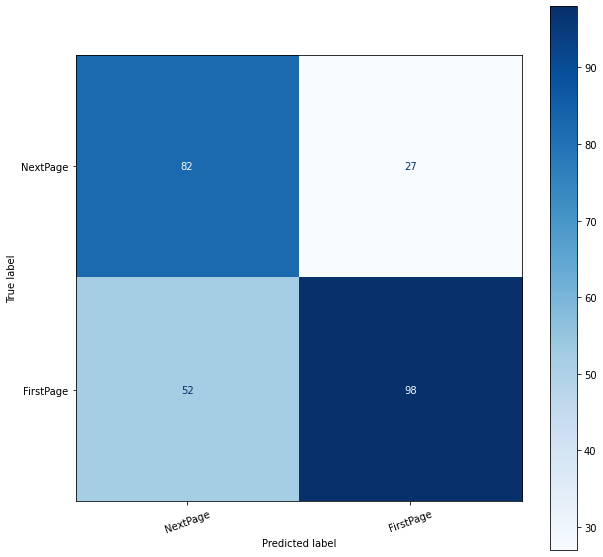

In [38]:
plot_confusion_matrix(labels, pred_labels, classes)

In [39]:
report_file_path = './report_final.json'
export_report(EXPERIMENT, 
              labels, 
              pred_labels, 
              list(classes.keys()),
              valid_loss, 
              valid_acc, 
              valid_kappa,               
              test_loss, 
              test_acc, 
              test_kappa, 
              report_file_path) 

{'tobacco800_input_1_classes_2_nn_effnetB0_14_FREEZE_BATCH_PRE_VALID': {'NextPage': {'precision': 0.6119402985074627, 'recall': 0.7522935779816514, 'f1-score': 0.6748971193415637, 'support': 109}, 'FirstPage': {'precision': 0.784, 'recall': 0.6533333333333333, 'f1-score': 0.7127272727272727, 'support': 150}, 'accuracy': 0.694980694980695, 'macro avg': {'precision': 0.6979701492537314, 'recall': 0.7028134556574923, 'f1-score': 0.6938121960344181, 'support': 259}, 'weighted avg': {'precision': 0.7115887742753415, 'recall': 0.694980694980695, 'f1-score': 0.6968064745842523, 'support': 259}, 'valid_acc': 0.6741071428571429, 'valid_kappa': 0.25208333827850005, 'test_acc': 0.6921296318372091, 'test_kappa': 0.3883889130788998}}


We'll then find out which predictions were incorrect and then sort these incorrect predictions by how confident our model was.

In [42]:
corrects = torch.eq(labels, pred_labels)

In [84]:
incorrect_examples = []

for image, label, prob, correct, file_name in zip(images, labels, probs, corrects, file_names):
    if not correct:
        incorrect_examples.append((image, label, prob, file_name))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

We can then plot these most confident incorrect predictions.

In [89]:
def plot_most_incorrect(incorrect, classes, n_images, file_names, normalize = True):

    rows = int(np.sqrt(n_images)) 
    cols = int(np.sqrt(n_images)) -1

    fig = plt.figure(figsize = (30, 25))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs, file_name = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        
        true_class = classes[true_label if type(true_label)==int else true_label.item()]
        incorrect_class = classes[incorrect_label if type(true_label)==int else incorrect_label.item()]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})\n' \
                     f'file: {file_name}\n')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

Again, the frog that was incorrectly labelled as a cat is there with a lot of automobile/truck confusion.

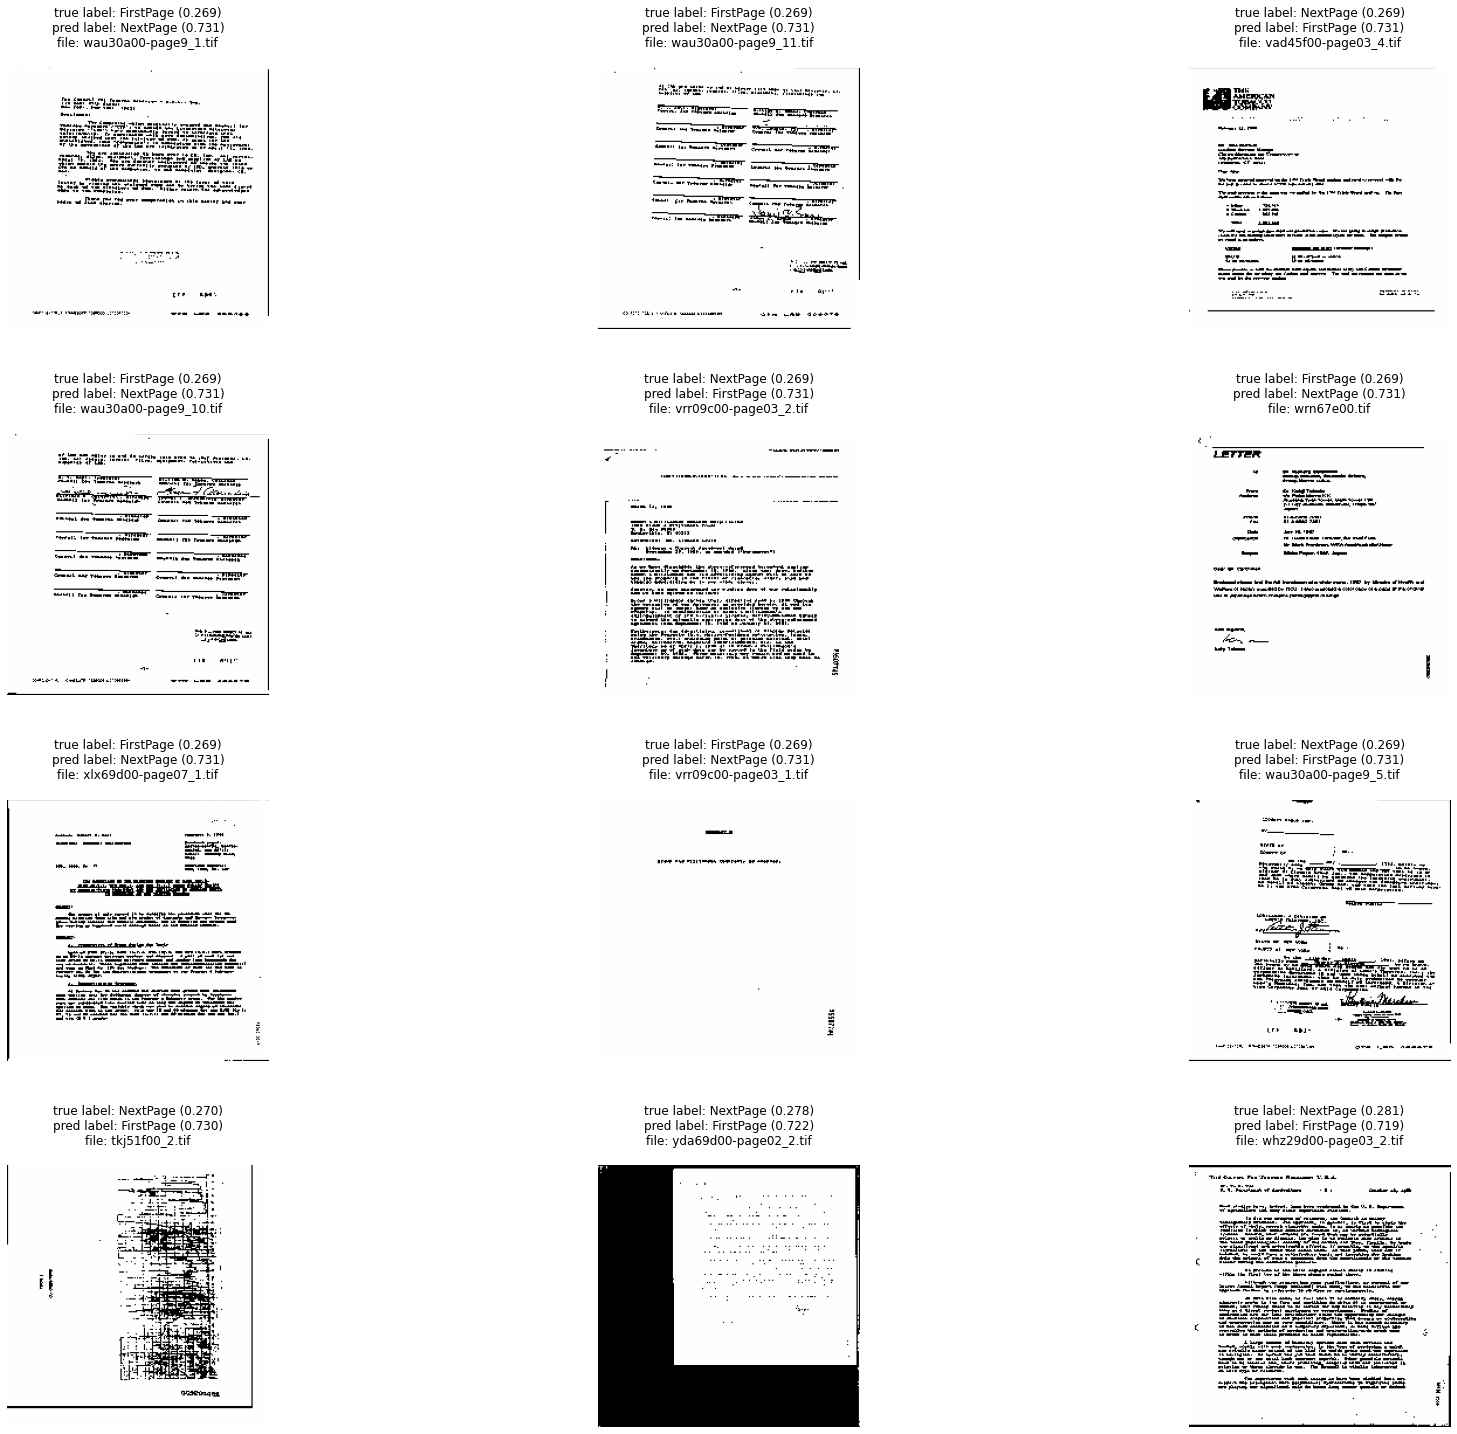

In [90]:
N_IMAGES = 36 if len(incorrect_examples) >= 36 else len(incorrect_examples)
classes = {1: 'FirstPage', 0: 'NextPage'}
plot_most_incorrect(incorrect_examples, classes, N_IMAGES, file_names)

Next up is plotting the representations of the model with PCA and then t-SNE.

We are only going to plot the output representations and not the intermediate ones here. This is because the output dimensions are two dimensional but the intermediate representations have over 25,000 dimensions and storing these in memory takes a considerably amount of RAM.

In [93]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y, _) in iterator:

            x = x.to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

First, we gets the output representations...

In [94]:
outputs, labels = get_representations(model, train_iterator)

Next, we define a function to perform PCA on the representations and plot the PCA output.

In [95]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [96]:
def plot_representations(data, labels, classes, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

We can then plot the PCA representations.

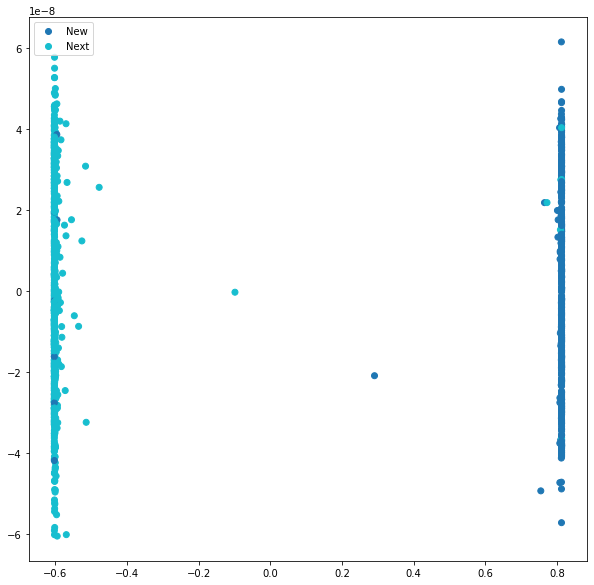

In [97]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, ['New','Next'])

Next up is calculating the t-SNE representations.

In [98]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

The t-SNE takes a lot longer to compute compared to PCA, thus we only use a sample of the representations to calculate the t-SNE embeddings.

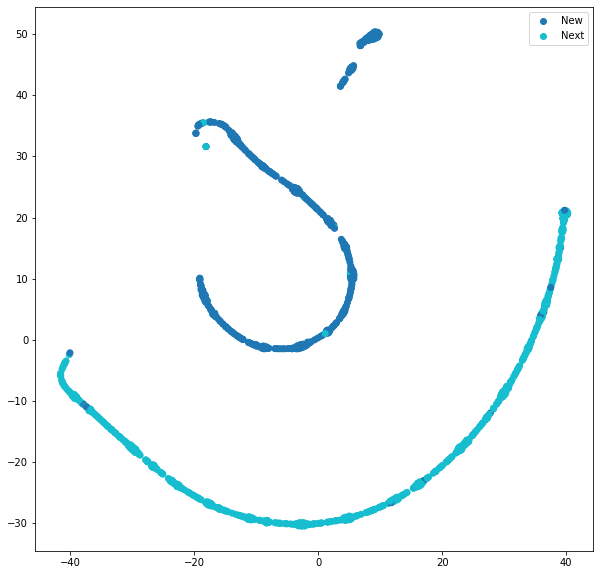

In [99]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
plot_representations(output_tsne_data, labels, ['New','Next'], n_images = N_IMAGES)

We'll then get the filters learned by our model and plot some images with the filters applied to them.

In [100]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

We can see that the filters learned by the model do different types of edge detection, color inversion and blurring.

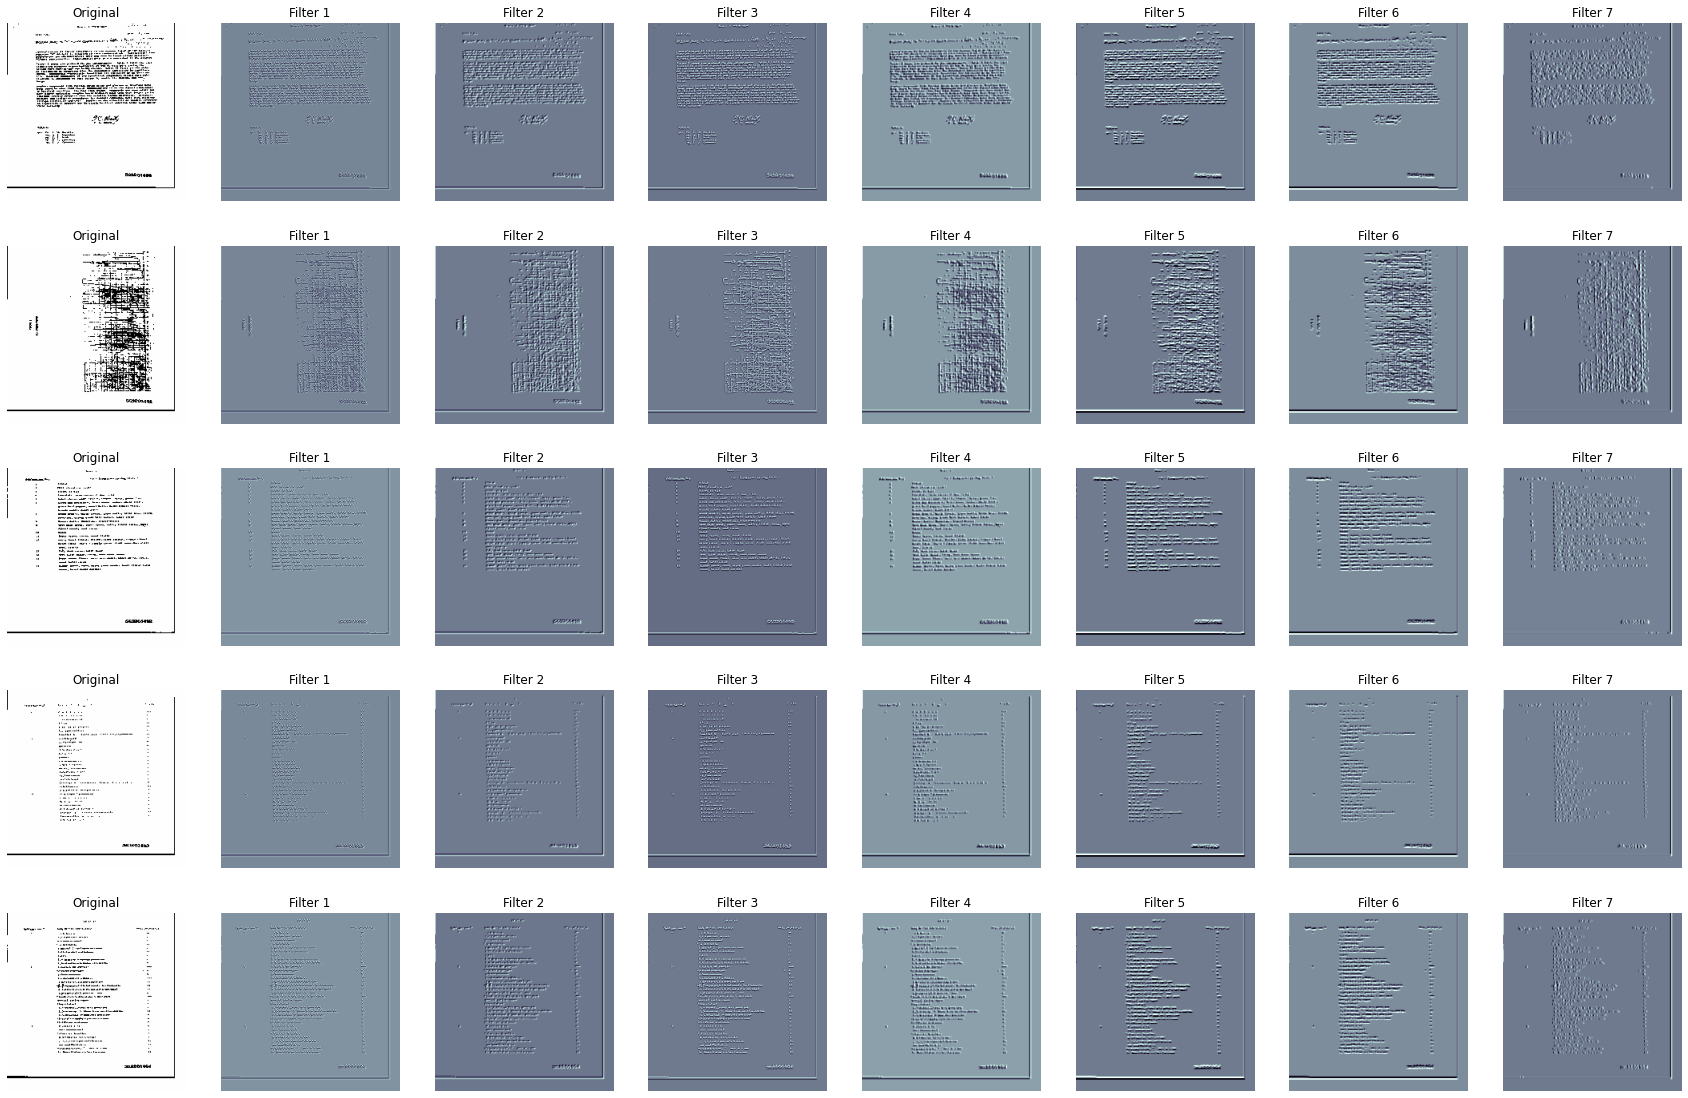

In [103]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label, _ in [valid_data[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)

We can also plot out the actual filter weights learned by the model.

In [104]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (20, 10))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace = -0.9)

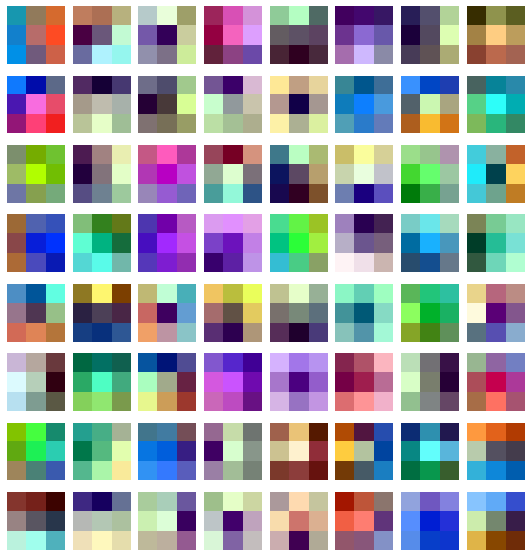

In [105]:
plot_filters(filters)